Import library and make directory on kaggle kernel

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))"

Import library and show first 10 row of the train.csv

In [4]:
import pandas as pd
train_csv = pd.read_csv('../input/indonesian-landmark/train.csv')
train_csv.head(10)

,id,landmark_id
0,img3,0
1,img6,0
2,img8,0
3,img9,0
4,img10,0
5,img14,0
6,img15,0
7,img16,0
8,img17,0
9,img24,0


In [5]:
len(train_csv)

1438

In [6]:
len(train_csv['landmark_id'].unique())

18

In [8]:
import matplotlib.image as img
import matplotlib.pyplot as plt

def show_img(file_name):
    base_path = '../input/indonesian-landmark/Train/'
    for path in os.listdir(base_path):
        for file in os.listdir(base_path+path):
            if file == file_name:
                image = img.imread('../input/indonesian-landmark/Train/'+path+'/'+file_name)
    plt.imshow(image)
    plt.show()

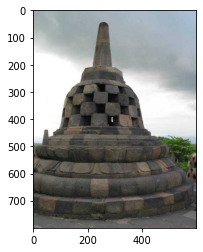

In [9]:
show_img('img10.jpg')

In [10]:

train_csv = pd.read_csv('../input/indonesian-landmark/train.csv')
train_csv.head(10)

# put .jpg into the file name
def add_txt(fn):
    return fn+'.jpg'

train_csv['id'] = train_csv['id'].apply(add_txt)



# choose those labels with more than 70 images, and choose the first 70 images of each label
# move every training files to the same folder
%cd /kaggle/working
if not os.path.exists('training'):
    os.mkdir('training')
if not os.path.exists('validation'):
    os.mkdir('validation')
# if not os.path.exists('testing'):
#     os.mkdir('testing')    

import shutil
import random

label_list = train_csv['landmark_id'].unique()
cnt = 0
final_label_list = []
base_path = '../input/indonesian-landmark/Train/'

for label in list(label_list): # label order by random
    file_list = list(train_csv['id'][train_csv['landmark_id']==label])
    if len(file_list) >= 70:
        final_label_list.append(label)
        if not os.path.exists('/kaggle/working/training/'+str(label)):
            os.mkdir('/kaggle/working/training/'+str(label))
        if not os.path.exists('/kaggle/working/validation/'+str(label)):
            os.mkdir('/kaggle/working/validation/'+str(label))
#         if not os.path.exists('/kaggle/working/testing/'+str(label)):
#             os.mkdir('/kaggle/working/testing/'+str(label))
        for file in file_list[:50]:  # 50 files for training
            for path in os.listdir(base_path):
                for file_name in os.listdir(base_path+path):
                    if file == file_name:
                        src = '../input/indonesian-landmark/Train/'+path+'/'+file
            dst = '/kaggle/working/training/'+str(label)+'/'+file
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)
        for file in file_list[50:70]: # 20 files for validation
            for path in os.listdir(base_path):
                for file_name in os.listdir(base_path+path):
                    if file == file_name:
                        src = '../input/indonesian-landmark/Train/'+path+'/'+file
            dst = '/kaggle/working/validation/'+str(label)+'/'+file
            if not os.path.exists(dst):
                shutil.copyfile(src, dst)
#         for file in file_list[160:200]: # 40 files for testing
#             src = '/kaggle/input/landmark-recognition-2020/train/'+file[0]+'/'+file[1]+'/'+file[2]+'/'+file
#             dst = '/kaggle/working/testing/'+str(label)+'/'+file
#             if not os.path.exists(dst):
#                 shutil.copyfile(src, dst)
        cnt += 1
    if cnt == 100: # only need 100 labels
        break
# 20,000 files in total

/kaggle/working


In [11]:
len(final_label_list)

18

In [12]:
print(len(os.listdir('./training')), len(os.listdir('./validation')))

18 18


In [13]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = '/kaggle/working/training'
validation_dir = '/kaggle/working/validation'
# test_dir = '/kaggle/working/testing'

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(300, 300),
    batch_size = 32,
    class_mode='categorical',
    seed=42)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(300, 300),
    batch_size = 32,
    class_mode='categorical',
    seed=42)

# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(300, 300),
#     batch_size = 1,
#     class_mode='categorical',
#     seed=42)

Found 900 images belonging to 18 classes.
Found 360 images belonging to 18 classes.


In [14]:
# test_generator.class_indices.keys()
train_generator.class_indices.keys()

dict_keys(['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '3', '4', '5', '6', '7', '8', '9'])

In [15]:
from tensorflow.keras.applications import MobileNetV2

conv_base = MobileNetV2(include_top=False,
                        weights="imagenet",
                        input_shape=(300, 300, 3)
)

conv_base.trainable = True

conv_base.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 150, 150, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 150, 150, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 150, 150, 32) 0           bn_Conv1[0][0]                   
________________

In [16]:
from keras.layers import Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, Flatten, Conv2D, Input
from keras.models import Sequential
from keras import optimizers
import tensorflow as tf

model = Sequential()
model.add(conv_base)
model.add(GlobalAveragePooling2D())
model.add(Dense(18, activation='softmax'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 10, 10, 1280)      2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 18)                23058     
Total params: 2,281,042
Trainable params: 2,246,930
Non-trainable params: 34,112
_________________________________________________________________


# Training

In [17]:
history = model.fit(
    train_generator,
    epochs=100, 
    validation_data=validation_generator
)


Epoch 1/100
29/29 [==============================] - 41s 1s/step - loss: 3.0856 - accuracy: 0.0486 - val_loss: 2.9216 - val_accuracy: 0.0722
Epoch 2/100
29/29 [==============================] - 28s 966ms/step - loss: 2.6826 - accuracy: 0.1629 - val_loss: 2.7474 - val_accuracy: 0.1389
Epoch 3/100
29/29 [==============================] - 28s 975ms/step - loss: 2.3699 - accuracy: 0.2996 - val_loss: 2.5888 - val_accuracy: 0.1944
Epoch 4/100
29/29 [==============================] - 27s 946ms/step - loss: 2.1246 - accuracy: 0.4501 - val_loss: 2.4381 - val_accuracy: 0.2361
Epoch 5/100
29/29 [==============================] - 27s 942ms/step - loss: 1.8558 - accuracy: 0.5766 - val_loss: 2.3044 - val_accuracy: 0.2972
Epoch 6/100
29/29 [==============================] - 28s 960ms/step - loss: 1.7027 - accuracy: 0.6022 - val_loss: 2.1680 - val_accuracy: 0.3083
Epoch 7/100
29/29 [==============================] - 28s 957ms/step - loss: 1.4768 - accuracy: 0.6670 - val_loss: 2.0679 - val_accuracy: 0.

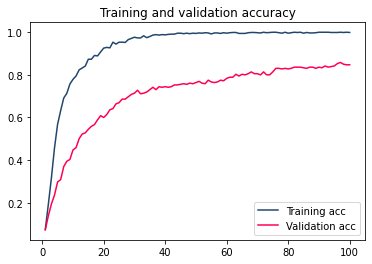

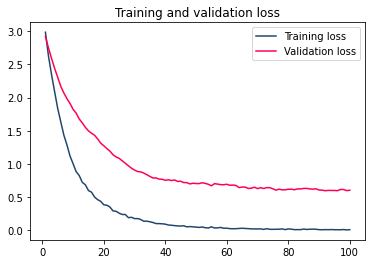

In [18]:
# plot the training results
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, '#21466C', label='Training acc')
plt.plot(epochs, val_acc, '#ff0051', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '#21466C', label='Training loss')
plt.plot(epochs, val_loss, '#ff0051', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Saving Model

In [20]:
model.save('./indonesia_landmark_model_MobileNetV2_100epoch.h5')

In [21]:
LANDMARK_MODEL= "./saved_100epoch"
tf.saved_model.save(model, LANDMARK_MODEL)

In [25]:
#ubah ke zip
!zip -r ./saved_100epoch.zip ./saved_100epoch

updating: saved_100epoch/ (stored 0%)
updating: saved_100epoch/saved_model.pb (deflated 93%)
updating: saved_100epoch/assets/ (stored 0%)
updating: saved_100epoch/variables/ (stored 0%)
updating: saved_100epoch/variables/variables.index (deflated 80%)
updating: saved_100epoch/variables/variables.data-00000-of-00001 (deflated 8%)


Make link of the file, so that we can download it.

In [26]:
from IPython.display import FileLink

FileLink(r'./indonesia_landmark_model_MobileNetV2_100epoch.h5')

/kaggle/working/indonesia_landmark_model_MobileNetV2_100epoch.h5